In [1]:
import os
os.path.abspath("")

'C:\\Users\\alexa\\Untitled Folder'

In [2]:
import os
import numpy as np
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import KNNBasic
from surprise import accuracy
import random 

#Para garantizar reproducibilidad en resultados
seed = 10
random.seed(seed)
np.random.seed(seed)

In [269]:
useridprofile = pd.read_csv('userid-profile.tsv', sep='\t')

In [4]:
file2 = pd.read_csv('userid-timestamp-artid-artname-traid-traname.tsv',sep='\t', nrows= 1000000, header=None,names=[
    "userid",
    "timestamp",  
    "musicbrainz-artist-id", 
    "artist-name",
    "artist-name musicbrainz-track-id", 
    "track-name",
]) 

In [5]:
type(useridprofile)

pandas.core.frame.DataFrame

In [6]:
useridprofile.head()

,#id,gender,age,country,registered
0,user_000001,m,NaN,Japan,"Aug 13, 2006"
1,user_000002,f,NaN,Peru,"Feb 24, 2006"
2,user_000003,m,22.0,United States,"Oct 30, 2005"
3,user_000004,f,NaN,NaN,"Apr 26, 2006"
4,user_000005,m,NaN,Bulgaria,"Jun 29, 2006"


In [7]:
file2.head(100)

,userid,timestamp,musicbrainz-artist-id,artist-name,artist-name musicbrainz-track-id,track-name
0,user_000001,2009-05-04T23:08:57Z,f1b1cf71-bd35-4e99-8624-24a6e15f133a,Deep Dish,NaN,Fuck Me Im Famous (Pacha Ibiza)-09-28-2007
1,user_000001,2009-05-04T13:54:10Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Composition 0919 (Live_2009_4_15)
2,user_000001,2009-05-04T13:52:04Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc2 (Live_2009_4_15)
3,user_000001,2009-05-04T13:42:52Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Hibari (Live_2009_4_15)
4,user_000001,2009-05-04T13:42:11Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc1 (Live_2009_4_15)
...,...,...,...,...,...,...
95,user_000001,2009-05-01T08:58:19Z,NaN,Ivan Enot,NaN,Grooves Of The Heart
96,user_000001,2009-05-01T08:52:36Z,1e68e986-e1f7-42ef-be43-086c858db02e,J. Boogie'S Dubtronic Science,66eb69ab-a5e3-4d17-92a6-754c898e4c86,Leave It All Behind (Feat. The Rebirth & Aima ...
97,user_000001,2009-05-01T08:45:19Z,c2fc3098-b9a5-41ab-b897-e6d67b097dfa,Home & Garden,820c1ffc-5a54-4d68-9603-765b83531578,Someday (Feat. Lisa Shaw)
98,user_000001,2009-05-01T08:41:49Z,278db520-adb6-4d27-a770-7539fa2e33b7,Kissey Asplund,NaN,Move Me [Feat. Soliloquy]


In [8]:
matriz = file2[["userid","track-name"]]

In [9]:
matriz.columns

Index(['userid', 'track-name'], dtype='object')

In [10]:
matriz.shape

(1000000, 2)

In [11]:
matriz.groupby(['userid'])['userid'].agg({'count'}).sort_values(by='count',ascending=False)

,count
userid,
user_000033,96436
user_000012,75876
user_000021,70446
user_000002,57438
user_000022,51474
user_000026,45308
user_000023,42010
user_000029,41830
user_000025,39082


In [12]:
df_count = matriz.groupby(['userid','track-name'], as_index=True)['track-name'].agg({'count'}).sort_values(by='count',ascending=False)

In [13]:
df_count.head()

count
userid      track-name                                   
user_000008 Heartless                                2119
            See You In My Nightmares                 2069
            Say You Will                             2065
            Love Lockdown                            2059
            Welcome To Heartbreak (Feat. Kid Cudi)   2059

In [14]:
type(df_count)

pandas.core.frame.DataFrame

In [15]:
df_count.columns

Index(['count'], dtype='object')

## Construcción de modelos colaborativos usuario-usuario

In [241]:
df2 = matriz.groupby(['userid','track-name'],as_index=False)['track-name'].agg({'count'}).reset_index()

In [242]:
df2[['userid', 'track-name']] = df2[['userid', 'track-name']].astype(str)

In [243]:
df2.dtypes

userid        object
track-name    object
count          int64
dtype: object

In [244]:
df2[df2['userid'] == 'user_000033'].shape

(6902, 3)

In [245]:
df2[df2['userid'] == 'user_000033'].sort_values(by='count',ascending=False)

,userid,track-name,count
175581,user_000033,Ryoujoku No Ame,880
171505,user_000033,Ain'T Afraid To Die,855
173723,user_000033,Itoshii Hito,753
176008,user_000033,Somnus Memoria,730
173931,user_000033,Kekkonshiki No Uta ~Kisetsu Hazure No Wedding ...,630
...,...,...,...
175986,user_000033,So Sad So Bad,1
175987,user_000033,So...,1
173134,user_000033,Gozen 0 Toki Ni Torauma Radio - Shiwase Na Hibi,1
173133,user_000033,Gozen 0 Ji No Abangyarudo,1


In [246]:
#We have to normalized "count" to make it in the form of our modele with ranking between 1 and 5
#Count Column represent the max of listening of a user for a single track
maxs = df2.groupby(['userid']).max().reset_index()
maxs.head(10)

,userid,track-name,count
0,user_000001,Ｔouch - A Mountain Of One Peyote Remix,70
1,user_000002,…,139
2,user_000003,[Untitled],47
3,user_000004,黒い涙 -Tv Live Edition-,308
4,user_000005,Що Ли Те Чакам Още,355
5,user_000006,Яппи - Гоу Хоум!,107
6,user_000007,¢Hunk Up Da Duece,22
7,user_000008,Život Napsal Sám (Feat. Jay Diesel),2119
8,user_000009,テイク 5,29
9,user_000010,_The_Dj_Was_My_Father_(Tom_Do,377


## Rating normalized creation

In [259]:
rating_normalized = []

n = len(df2['userid'])

df_userid = df2['userid']
df_count = df2['count'].tolist()

for i in range(n):
    
    userId =  df_userid[i]
    
    max_user_items = maxs[maxs['userid'] == userId]['count'].iloc[0]
    
    #Rating normalized between 0 and 5
    rating_normalized.append(5 * (df_count[i]) / max_user_items)
    
for i in range(n):
    
    #Rating normalized between 1 and 5
    rating_normalized[i] = (4*rating_normalized[i] + 5)/5
        
df2['rating_normalized'] = rating_normalized
print("Done")

Done


In [260]:
df2['rating_normalized'] = df2['rating_normalized'].astype(float)
display(df2.dtypes)

userid                object
track-name            object
count                  int64
rating_normalized    float64
dtype: object

In [261]:
df2.head(100)

,userid,track-name,count,rating_normalized
0,user_000001,'84 Pontiac Dream,14,1.800000
1,user_000001,(All I Wanted Was To Make You) Feel Good,3,1.171429
2,user_000001,(D)Ecaying Beauty,1,1.057143
3,user_000001,(Far From) Home,1,1.057143
4,user_000001,(Get Off Your) High Horse Lady,1,1.057143
...,...,...,...,...
95,user_000001,Air Vibes,1,1.057143
96,user_000001,Akropolis,7,1.400000
97,user_000001,"Al-Falaq 113 Featuring Mino Cinelu, Gene Lake,...",1,1.057143
98,user_000001,Alarm Call,4,1.228571


In [298]:
df2[df2['userid'] == 'user_000033'].sort_values(by='count',ascending=False)

,userid,track-name,count,rating_normalized
175581,user_000033,Ryoujoku No Ame,880,5.000000
171505,user_000033,Ain'T Afraid To Die,855,4.886364
173723,user_000033,Itoshii Hito,753,4.422727
176008,user_000033,Somnus Memoria,730,4.318182
173931,user_000033,Kekkonshiki No Uta ~Kisetsu Hazure No Wedding ...,630,3.863636
...,...,...,...,...
175986,user_000033,So Sad So Bad,1,1.004545
175987,user_000033,So...,1,1.004545
173134,user_000033,Gozen 0 Toki Ni Torauma Radio - Shiwase Na Hibi,1,1.004545
173133,user_000033,Gozen 0 Ji No Abangyarudo,1,1.004545


# Ahora construyamos la matriz de utilidad

In [453]:
#mu = Matrix de Utilidad
useridprofile['index'] = range(len(useridprofile))

def matrix_utilidad(i):
    '''Return the matrix of utility of the user i'''
    
    userid = useridprofile.loc[useridprofile['index'] == i, '#id'].iloc[0]
    print("UserId : " + userid)
    onlytrack_ui = df2.loc[df2['userid'] == userid, ['userid','track-name']]
    #onlytrack_ui.drop_duplicates(keep = 'first', inplace = True)
    onlytrack_ui['index'] = range(len(onlytrack_ui))
    
    
    nb_track = len(onlytrack_ui)
    
    neighbour_ui = df2[df2['track-name'].isin(onlytrack_ui['track-name'])]
    nb_neighbour = len(neighbour_ui['userid'].drop_duplicates(keep = 'first', inplace = False))

    print("Tenemos " + str(nb_user - 1) + " usuarios vecinos")
    print("Tenemos " + str(nb_track) + " tracks")

    mu = np.zeros((nb_neighbour, nb_track))

    for k in neighbour_ui.index:
        
        useridk = neighbour_ui.loc[k, 'userid']
        tracknamek = neighbour_ui.loc[k, 'track-name']

        num_user = useridprofile[useridprofile['#id'] == useridk]['index'].iloc[0]
        num_track = onlytrack_ui.loc[onlytrack_ui['track-name'] == tracknamek, 'index'].iloc[0]

        mu[num_user][num_track] = df2['rating_normalized'][k]

    mu2 = np.array(mu)
    #print(mu2)
    
    return mu2


In [454]:
matrix_utilidad(0)

UserId : user_000001
Tenemos 991 usuarios vecinos
Tenemos 3092 tracks


array([[1.8       , 1.17142857, 1.05714286, ..., 1.22857143, 1.17142857,
        1.05714286],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## Vamos a determinar los simitudes entre el usuario x y los otros

In [455]:
def similitudes(x, mu):
    '''Return similitudes of user X with the other users'''
    
    usarioX = mu[x] 

    norm_uX = np.dot(usarioX, usarioX)

    sim = []

    for i in range(len(mu)):
    
        scal = np.dot(usarioX, mu[i])
        norm_ui = np.dot(mu[i], mu[i])
        
        sim_coseno = 0
        if not ((norm_uX == 0) or (np.isnan(norm_uX)) or (norm_ui == 0) or (np.isnan(norm_ui))):
            sim_coseno = scal / (norm_uX * norm_ui)
            
        sim.append(sim_coseno)
        
    return sim
    

## Vamos a hacer predicciones de relevancia con un modelo basado en distancias coseno

In [534]:
def prediccion(i, j, mu, sim):
    
    rating_means = []
    n = len(mu)
    
    sum1 = 0
            
    rating_means.append(np.mean(np.array(mu[i])))
    
    for k in range(n):
        
        if (k!= i):
            sum1 += sim[k]*(mu[k][j] - rating_means[k])
    
    
    sum2 = np.sum(np.array(sim))
        
    pred = rating_means[0] + (sum1/sum2)
    
    print("La predicciones para el usario " + str(i) + " y para el item " + str(j) + " es : " + str(pred))
    
    return pred



In [535]:
#Test prediccion

mui = matrix_utilidad(0)
sim = similitudes(0, mui)
pred = prediccion(0, 0, mui, sim)

UserId : user_000001
Tenemos 991 usuarios vecinos
Tenemos 3092 tracks


IndexError: list index out of range

## Vamos a medir la cualidad de esos predicciones

In [486]:
import time as t

def funcion_costo(n, m, prediccion, similitude):
    # n = Number of users for test
    # m = Number of items for test

    start = t.time()

    #Evaluamos sus distancias con el funcion costo quien es proportional a la distancia euclidian entre las prediccions y las datas
    funcion_costo = 0

    for i in range(n):
    
        mu = matrix_utilidad(i)
        sim = similitude(i, mu)
        
        for j in range(m):
            
            pred = prediccion(i, j, mu, sim)
            
            funcion_costo += (pred - mu[i][j])**2

    funcion_costo = funcion_costo / (2*n*m) 

    tiempo1 = t.time() - start
    print("\nTiempo de ejecucion : " + str(duree))

    print("`Modelo collaborativo usuario-usuario")
    print("El function de costo o la cualidad de esos predicciones es de : " + str(funcion_costo))
    
    return tiempo1, funcion_costo

In [487]:
tiempo1, funcion_costo1 = funcion_costo(5, 5, prediccion, similitudes)

UserId : user_000001
Tenemos 991 usuarios vecinos
Tenemos 3092 tracks
La predicciones para el usario 0 y para el item 0 es : 0.23468645872219884
La predicciones para el usario 0 y para el item 1 es : 0.05066718008767057
La predicciones para el usario 0 y para el item 2 es : 0.0333063124875439
La predicciones para el usario 0 y para el item 3 es : 0.08653896369811687
La predicciones para el usario 0 y para el item 4 es : 0.09365412346515556
UserId : user_000002
Tenemos 991 usuarios vecinos
Tenemos 8129 tracks
La predicciones para el usario 1 y para el item 0 es : 0.049074649000160786
La predicciones para el usario 1 y para el item 1 es : 0.026382909568067214
La predicciones para el usario 1 y para el item 2 es : 0.026382909568067214
La predicciones para el usario 1 y para el item 3 es : 0.026382909568067214
La predicciones para el usario 1 y para el item 4 es : 0.026382909568067214
UserId : user_000003
Tenemos 991 usuarios vecinos
Tenemos 4565 tracks
La predicciones para el usario 2 y p

## Nueva estrategia de seleccion de vecinos por umbral de similitud y por numero de vecinos

In [492]:
def better_prediccion(i,j, mu, sim):
    
    better_sim = []
    
    #Amplication x1000 and threshold
    sim_ampli = [1000*s for s in sim if s >=0.0002]
    sim_ampli.sort()
    
    #N es el numero maxima de vecinos
    N = min(len(sim_ampli), 100)
    
    better_sim = []
    
    for i in range(N):
        if sim_ampli[i] > 1:
            better_sim.append(1)
        else:
            better_sim.append(sim_ampli[i])
    
    rating_means = []
    sum1 = 0
    pred = 0
    
    if(N != 0):
        for k in range(N):
            rating_means.append(np.mean(np.array(mu2[i])))
        
            if (k != i):
                sum1 += better_sim[k]*(mu2[k][j] - rating_means[k])
    
        sum2 = np.sum(np.array(better_sim))
        
        pred = rating_means[0] + (sum1/sum2)
    
    return pred

In [494]:
tiempo2, funcion_costo2 = funcion_costo(5, 5, better_prediccion, similitudes)

UserId : user_000001
Tenemos 991 usuarios vecinos
Tenemos 3092 tracks
UserId : user_000002
Tenemos 991 usuarios vecinos
Tenemos 8129 tracks
UserId : user_000003
Tenemos 991 usuarios vecinos
Tenemos 4565 tracks
UserId : user_000004
Tenemos 991 usuarios vecinos
Tenemos 5974 tracks
UserId : user_000005
Tenemos 991 usuarios vecinos
Tenemos 1974 tracks

Tiempo de ejecucion : 72.84301590919495
`Modelo collaborativo usuario-usuario
El function de costo o la cualidad de esos predicciones es de : 0.5714733065278436


In [496]:
#pip install --upgrade matplotlib

Note: you may need to restart the kernel to use updated packages.


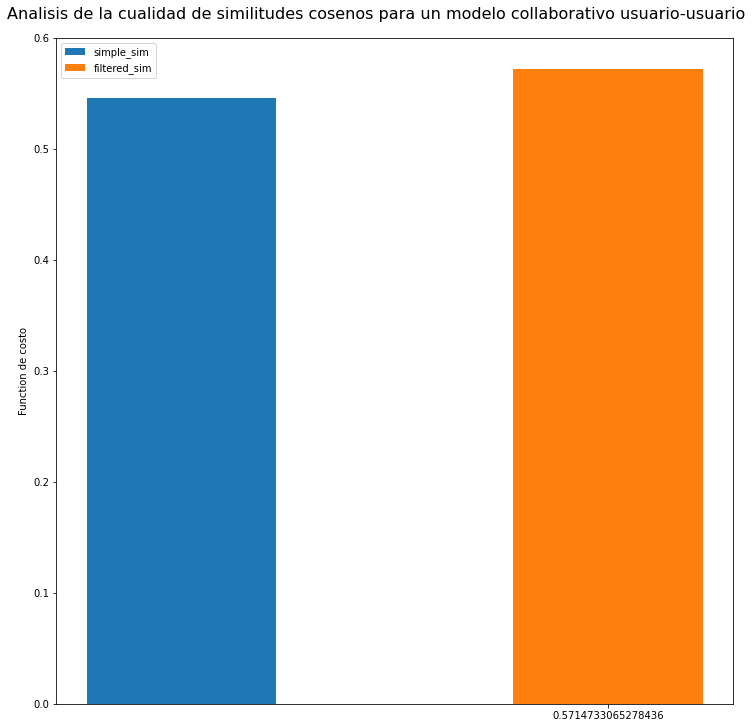

In [525]:
import matplotlib.pyplot as plt

cualidad_analyse = {
    'simple_sim': (funcion_costo1),
    'filtered_sim': (funcion_costo2), 
}

cases = ("Simple Similitude", "Filtered Similitude")
x = np.arange(len(cases))
widthBar = 0.8
multiplier = 0

fig, axe = plt.subplots(constrained_layout = True,figsize=(10,10))
    

#Pantalla gráfica para comparar el rendimiento y la cualidad

for sim, measurement in cualidad_analyse.items():
    offset = widthBar * multiplier
    
    bar1 = axe.bar(x[multiplier] + offset, height = measurement, width = widthBar, label=sim, tick_label = measurement)
    #axe.bar_label(bar1, padding=3)
    multiplier += 1


axe.set_ylabel("Function de costo")
axe.legend(loc='upper left')
fig.suptitle("Analisis de la cualidad de similitudes cosenos para un modelo collaborativo usuario-usuario", fontsize=16);

In [489]:
#Test prediccion
tiempo2, funcion_costo2 = funcion_costo(5, 5, better_prediccion, similitudes)

UserId : user_000001
Tenemos 991 usuarios vecinos
Tenemos 3092 tracks
UserId : user_000002
Tenemos 991 usuarios vecinos
Tenemos 8129 tracks
UserId : user_000003
Tenemos 991 usuarios vecinos
Tenemos 4565 tracks
UserId : user_000004
Tenemos 991 usuarios vecinos
Tenemos 5974 tracks
UserId : user_000005
Tenemos 991 usuarios vecinos
Tenemos 1974 tracks

Tiempo de ejecucion : 72.84301590919495
`Modelo collaborativo usuario-usuario
El function de costo o la cualidad de esos predicciones es de : 0.5714733065278436


## Lo mismo para un modelo colaborativo item-item

In [526]:
def similitudes2(x, mu):
    '''Return similitudes of item X with the other items'''
    
    mut = np.transpose(mu)
    
    itemX = mut[x]

    norm_iX = np.dot(itemX, itemX)

    sim = []

    for i in range(len(mut)):
    
        scal = np.dot(itemX, mut[i])
        norm_ii = np.dot(mut[i], mut[i])
    
        sim_coseno = 0
        
        if not ((norm_uX == 0) or (np.isnan(norm_uX)) or (norm_ui == 0) or (np.isnan(norm_ui))):
            sim_coseno = scal / (norm_uX * norm_ui)
            
        sim.append(sim_coseno)
        
    return sim

In [532]:
def prediccion2(i, j, mu, sim):
    
    rating_means = []
    
    mut = np.transpose(mu)
    n = len(mut)
    for i in range(n):
        rating_means.append(np.mean(np.array(mut[i])))
        
    rating_means.append(np.mean(np.array(mut[i])))
    
    sum1 = 0
    
    for k in range(n):
        
        if (k!= i):
            sum1 += sim[k]*(mut[k][j] - rating_means[k+1])
    
    sum2 = np.sum(np.array(sim))
        
    pred = rating_means[0] + (sum1/sum2)
    
    print("La predicciones para el usario " + str(i) + " y para el item " + str(j) + " es : " + str(pred))
    
    return pred

In [533]:
tiempo3, funcion_costo3 = funcion_costo(5, 5, prediccion2, similitudes)

UserId : user_000001
Tenemos 991 usuarios vecinos
Tenemos 3092 tracks


IndexError: list index out of range